# Kuramoto-Sivashinsky equation

\begin{cases}
\dfrac{\partial u(x,t)}{\partial t} + \dfrac{\partial^2 u(x,t)}{\partial x^2} + \nu\dfrac{\partial^4 u(x,t)}{\partial x^4} + u(x,t)\dfrac{\partial u(x,t)}{\partial x} = 0 \qquad &\mathrm{in } \ (0,L) \times (0,T)
\\[7pt]
u(0,t) = u(L,t) \qquad &\mathrm{on } \ \{x=0,x=L\} \times (0,T)
\\[7pt]
\dfrac{\partial u(0,t)}{\partial x} = \dfrac{\partial u(L,t)}{\partial x} \qquad &\mathrm{on } \ \{x=0,x=L\} \times (0,T)
\\[7pt]
\dfrac{\partial^2 u(0,t)}{\partial x^2}  = \dfrac{\partial^2 u(L,t)}{\partial x^2} \qquad &\mathrm{on } \ \{x=0,x=L\} \times (0,T)
\\[7pt]
\dfrac{\partial^3 u(0,t)}{\partial x^3} = \dfrac{\partial^3 u(L,t)}{\partial x^3} \qquad &\mathrm{on } \ \{x=0,x=L\} \times (0,T)
\\[7pt]
u(x,0) = \cos \left( \frac{2 \pi \omega}{L}x \right) \left(1 + \sin \left( \frac{2 \pi \omega}{L}x \right) \right) \qquad & \mathrm{in} \ (0,L) \times \{t=0\}
\end{cases}


where $L$ is the domain length, $T > 0$ is the final time, $u: [0,L] \times [0,T] \to \mathbb{R}$ is the unknown field, $\nu$ is the viscosity and $\omega$ is the initial condition frequency  

In [2]:
#IMPORT LIBRARIES

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from __future__ import print_function
from IPython.display import clear_output as clc
import cmcrameri.cm as cmc

plt.style.use('default')

In [3]:
# DOMAIN DISCRETIZATION

nstate = 100
L = 22
x = np.linspace(0, L, nstate)

In [4]:
# DEFINE THE STATE PROBLEM SOLVER

from tqdm import tqdm

def compute_state(nu, omega, dt, T, nstepsoutput = 300):
    """
    Compute the state trajectory
    Input: viscosity, initial condition frequency, time step, final time and number of steps to return
    Output: time-dependent state
    Credits: https://github.com/E-Renshaw/kuramoto-sivashinsky
    """

    u0 = lambda x: np.cos(omega * 2 * np.pi * x / L) * (1 + np.sin(omega * 2 * np.pi * x / L)) # initial condition

    v = np.fft.fft(u0(x))
    
    # Scalars for the Exponential Time Differencing fourth-order Runge-Kutta (ETDRK4)
    domain_length = x[-1] - x[0]
    k = 2 * np.pi / domain_length * np.transpose(np.conj(np.concatenate((np.arange(0, nstate/2), np.array([0]), np.arange(-nstate/2+1, 0))))) 
    l = k**2 - nu * k**4
    E = np.exp(dt*l)
    E2 = np.exp(dt*l/2)
    
    M = 16
    r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
    LR = dt*np.transpose(np.repeat([l], M, axis=0)) + np.repeat([r], nstate, axis=0)
    Q  = dt*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
    f1 = dt*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
    f2 = dt*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
    f3 = dt*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))
    
    u = np.array([u0(x)])
    ntimesteps = round(T / dt)
    freqoutput = round((T / nstepsoutput) / dt)
    g = -0.5j*k
    
    for i in tqdm(range(1, ntimesteps + 1), colour = "cyan", file = sys.stdout, bar_format = 'Computing state |{bar}| {n}/{total} {elapsed}<{remaining}'):
        Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2)
        a = E2*v + Q*Nv
        Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2)
        b = E2*v + Q*Na
        Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2)
        c = E2*a + Q*(2*Nb-Nv)
        Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2)
        v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
        if i % freqoutput == 0:
            un = np.real(np.fft.ifft(v))
            u = np.append(u, np.array([un]), axis=0)
            
    return torch.from_numpy(u)

In [6]:
# SOLVE THE STATE PROBLEM

dt = 1e-2
T = 200.0
nstepsoutput = 200

nu = 1.5
omega = 3.0
        
ut = compute_state(nu, omega, dt, T, nstepsoutput)

Computing state |██████████| 20000/20000 00:02<00:00


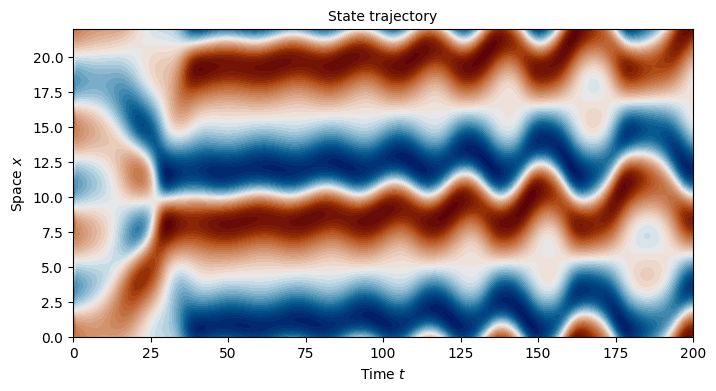

In [7]:
# STATE TRAJECTORY (PLOT)

def plot_state(u, cmap = cmc.vik, title = None, fontsize = None, ticks = True, colorbar = True, levels = 50, vmax = None, vmin = None):
    """
    State trajectory
    Input: state trajectory with dimension (ntimes, nstate) and plot functionalities
    """

    times = np.linspace(0, T, u.shape[0])
    timesgrid, xgrid = np.meshgrid(times, x)
    
    fig = plt.contourf(timesgrid, xgrid, u.t(), cmap = cmap, levels = levels, vmax = vmax, vmin = vmin)
    
    plt.xlabel(r"Time $t$", fontsize = fontsize)
    plt.ylabel(r"Space $x$", fontsize = fontsize)
    plt.xlim(times[0], times[-1])
    plt.ylim((x[0], x[-1]))
    plt.title(title, fontsize = fontsize)

    if not ticks:
        plt.xticks([], [])
        plt.yticks([], [])
        
    if colorbar:
        plt.colorbar(fig)

plt.figure(figsize = (8,4))
plot_state(ut, colorbar = False, title = "State trajectory")

# Snapshots generation

In [8]:
# GENERATE SNAPSHOTS (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

dt = 1e-2
T = 200.0
nstepsoutput = 200
ntimes = nstepsoutput + 1 # Time series length

ntrajectories = 500
nparams = 2

params_range = [(1.0, 2.0), (1.0, 5.0)] # Physical parameters: viscosity and initial condition frequency

filename = 'KuramotoSivashinsky_data'
U = torch.zeros(ntrajectories, ntimes, nstate)
MU = torch.zeros(ntrajectories, ntimes, nparams)

for i in range(ntrajectories):

    print(f"Generating snapshots n.{i}...")
    
    params = [0] * len(params_range)
    for j in range(len(params_range)):
        params[j] = ((params_range[j][1] - params_range[j][0]) * torch.rand(1) + params_range[j][0]).item()  
    
    ut = compute_state(params[0], params[1], dt, T, nstepsoutput)

    # U[i] = torch.from_numpy(ut)
    U[i] = ut
    for j in range(ntimes):
        MU[i,j] = torch.tensor(params)

    clc(wait = True)

print("Snapshots generated!")

np.savez("%s.npz" % filename.replace(".npz",""), u = U, mu = MU)

Generating snapshots n.1...
Computing state |███████▊  | 15502/20000 00:02<00:00


KeyboardInterrupt: 

In [9]:
# LOAD SNAPSHOTS MATRICES

dt = 1e-2
T = 200.0
nstepsoutput = 200
ntimes = nstepsoutput + 1 # Time series length

ntrajectories = 500
nparams = 2

filename = 'KuramotoSivashinsky_data'
Data = np.load("%s.npz" % filename.replace(".npz",""))
U = torch.tensor(Data["u"])
MU = torch.tensor(Data["mu"])

del Data

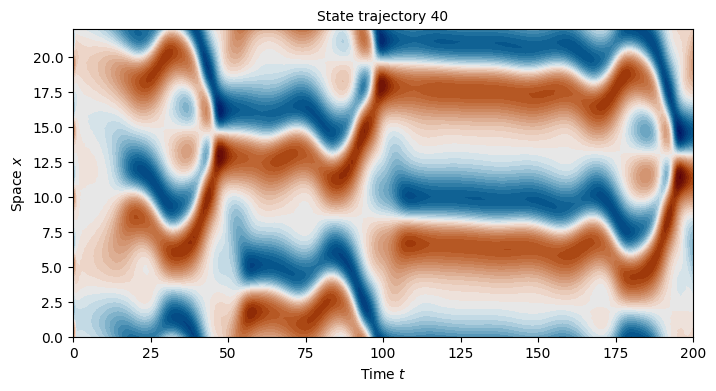

In [13]:
# TRAJECTORY EXAMPLE (PLOT)

which = 40

plt.figure(figsize = (8,4))
plot_state(U[which], colorbar = False, title = f"State trajectory {which}")

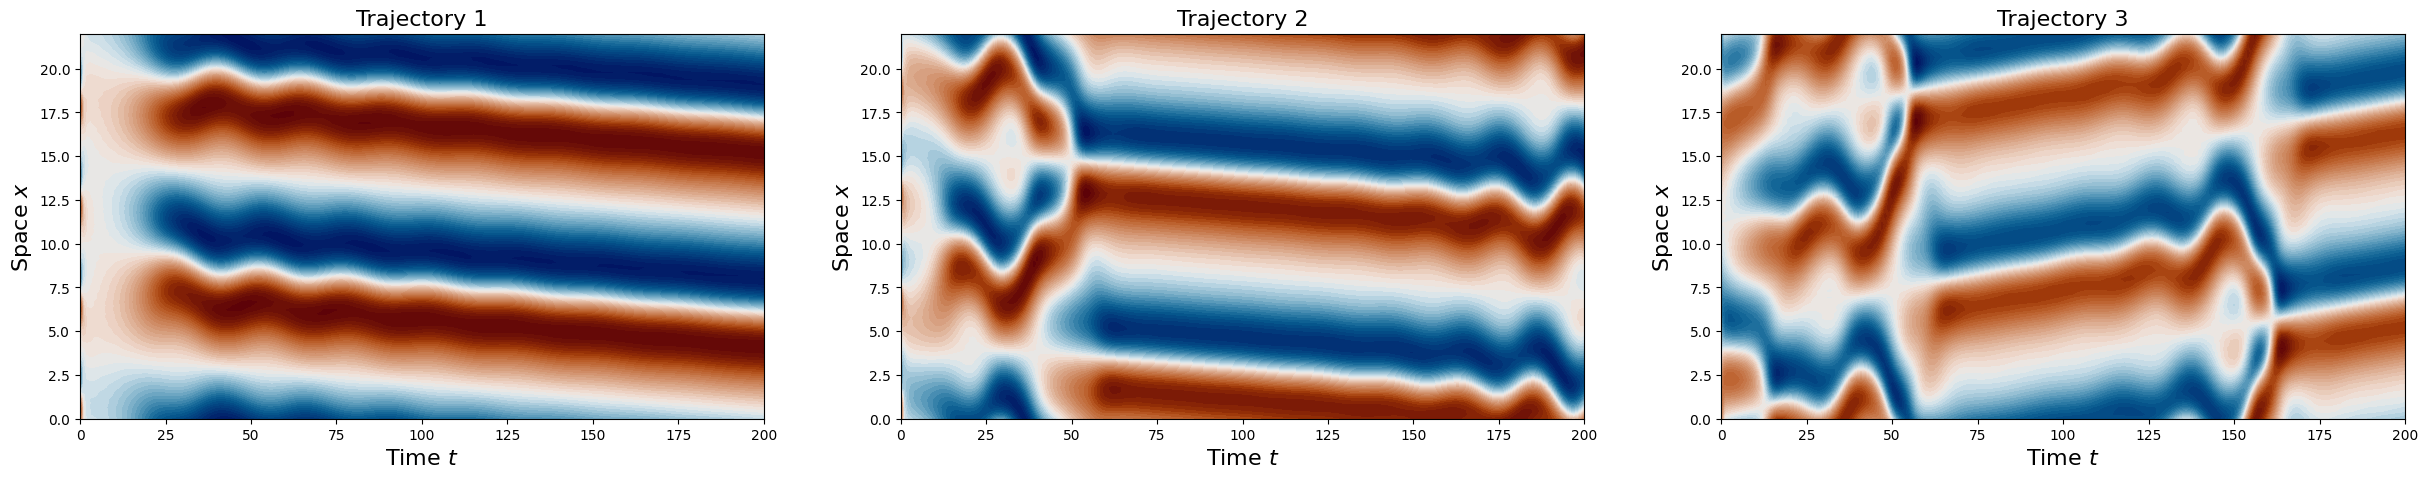

In [14]:
# TRAJECTORY EXAMPLES (PLOT)

from utils.processdata import multiplot

which = (0, 1, 2)
plotlist = [U[which[0]], U[which[1]], U[which[2]]]

plot_state_wrapper = lambda u: plot_state(u, colorbar = False, fontsize = 16)

multiplot(plotlist, plot_state_wrapper, titles = ("Trajectory 1", "Trajectory 2", "Trajectory 3"), fontsize = 16, figsize = (30,5), axis = True)

In [15]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed(0)

ntrain = round(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

Utrain = U[idx_train]
Uvalid = U[idx_valid]
Utest = U[idx_test]
MUtrain = MU[idx_train]
MUvalid = MU[idx_valid]
MUtest = MU[idx_test]

del U, MU

# State reduction - POD

In [16]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mre, num2p # Error metrics and format

In [17]:
# RESHAPE MATRICES

Utrain = Utrain.reshape(-1, nstate).numpy()
Uvalid = Uvalid.reshape(-1, nstate).numpy()
Utest = Utest.reshape(-1, nstate).numpy()

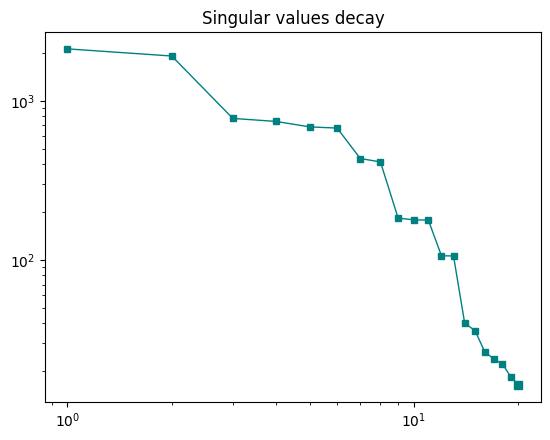

In [21]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION FOR U

from sklearn.utils.extmath import randomized_svd

kstate = 20 # Number of POD modes

W, S, V = randomized_svd(Utrain, n_components = kstate)

teal = sns.light_palette("teal", 15)
plt.plot([i for i in range(1, kstate + 1)], S, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kstate, S[kstate-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay");

Utrain_POD = Utrain @ V.transpose()
Uvalid_POD = Uvalid @ V.transpose()
Utest_POD = Utest @ V.transpose()
Utrain_reconstructed = W @ np.diag(S) @ V
Uvalid_reconstructed = Uvalid @ V.transpose() @ V
Utest_reconstructed = Utest @ V.transpose() @ V

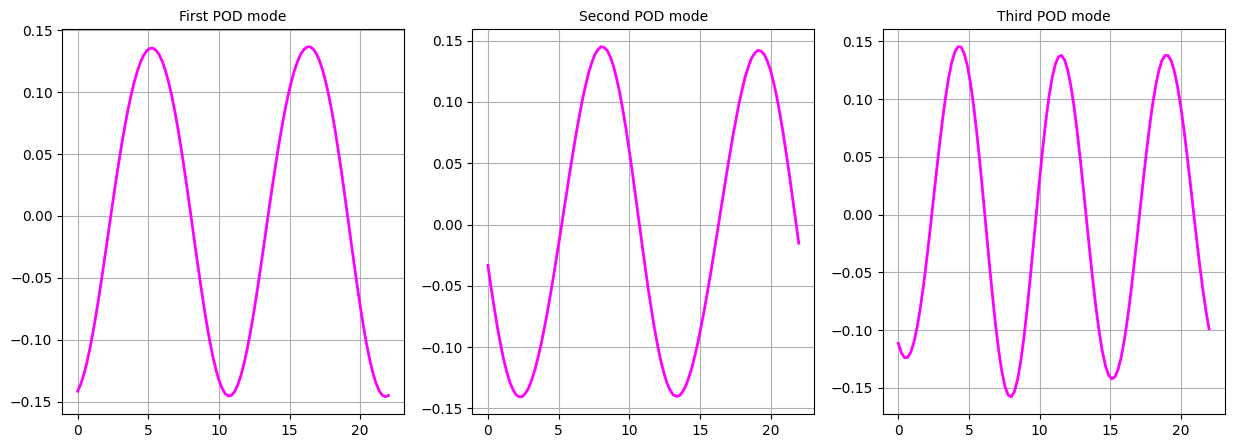

In [22]:
# POD MODES (PLOT)

plotlist = [V[0], V[1], V[2]]

def plot_mode(u, title = None, colorbar = False):  
    """
    POD mode
    Input: POD mode with dimension (nstate) and plot functionalities
    """

    plt.plot(x, u, color = "magenta", linewidth = 2)
    plt.grid()

multiplot(plotlist, plot_mode, titles = ("First POD mode", "Second POD mode", "Third POD mode"), axis = True, figsize = (15, 5))

In [24]:
# SCALING

from sklearn.preprocessing import MinMaxScaler

scalerU = MinMaxScaler()
scalerU = scalerU.fit(Utrain_POD)
Utrain_POD = scalerU.transform(Utrain_POD)
Uvalid_POD = scalerU.transform(Uvalid_POD)
Utest_POD = scalerU.transform(Utest_POD)

In [28]:
# RESHAPE MATRICES

Utrain = torch.from_numpy(Utrain.reshape(ntrain, ntimes, nstate))
Uvalid = torch.from_numpy(Uvalid.reshape(nvalid, ntimes, nstate))
Utest = torch.from_numpy(Utest.reshape(ntest, ntimes, nstate))
Utrain_POD = torch.from_numpy(Utrain_POD.reshape(ntrain, ntimes, kstate))
Uvalid_POD = torch.from_numpy(Uvalid_POD.reshape(nvalid, ntimes, kstate))
Utest_POD = torch.from_numpy(Utest_POD.reshape(ntest, ntimes, kstate))
Utrain_reconstructed = torch.from_numpy(Utrain_reconstructed.reshape(ntrain, ntimes, nstate))
Uvalid_reconstructed = torch.from_numpy(Uvalid_reconstructed.reshape(nvalid, ntimes, nstate))
Utest_reconstructed = torch.from_numpy(Utest_reconstructed.reshape(ntest, ntimes, nstate))

In [29]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

print("Mean relative POD reconstruction error on U: %s" % num2p(mre(Utest, Utest_reconstructed)))

Mean relative POD reconstruction error on U: 0.52%


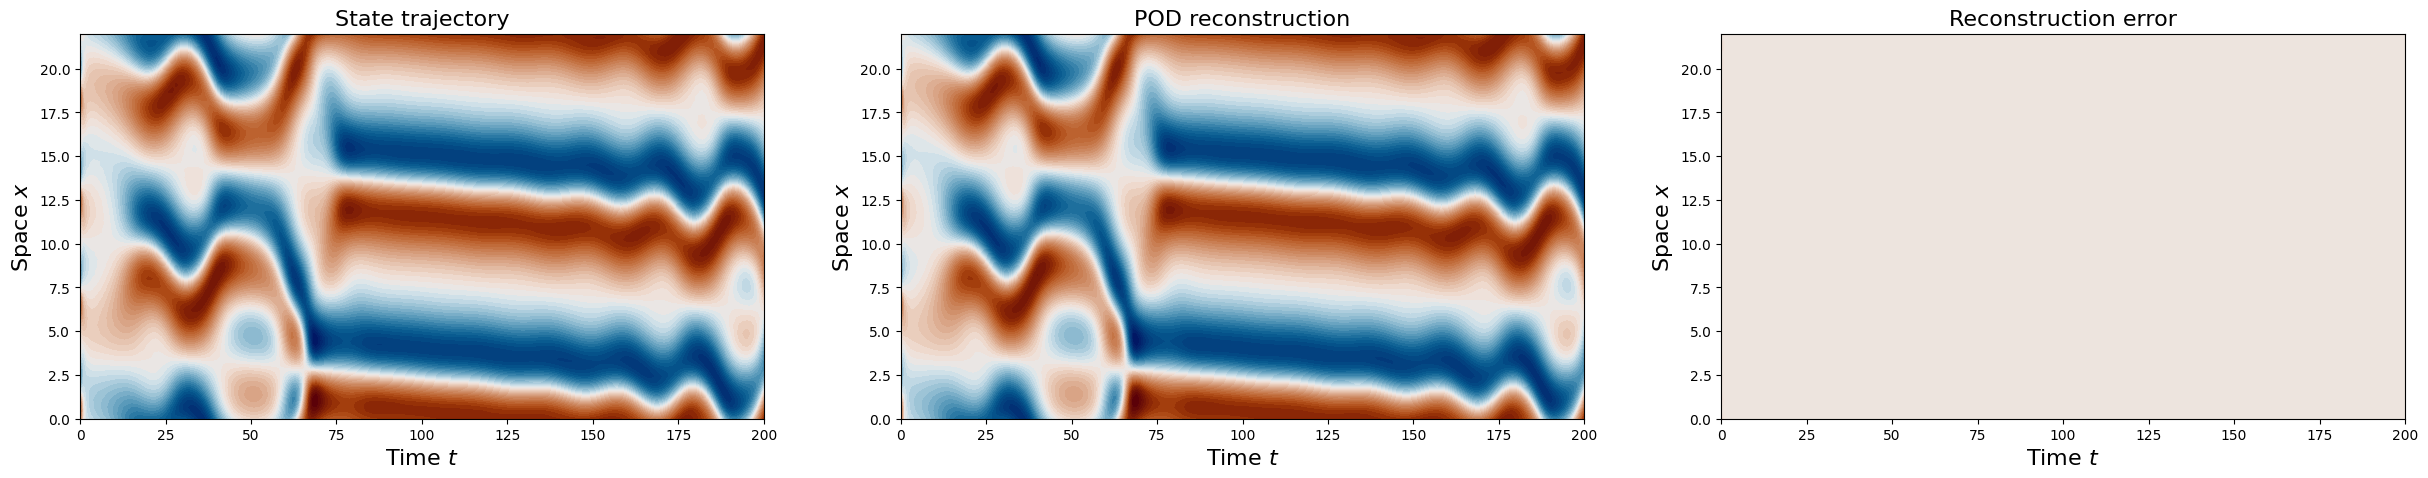

In [30]:
# FOM vs POD RECONSTRUCTION (PLOTS)

which = 10 

plotlist = [Utest[which], Utest_reconstructed[which], ((Utest[which] - Utest_reconstructed[which])**2).sqrt()]
vmin = min(plotlist[i].min() for i in range(len(plotlist)))
vmax = max(plotlist[i].max() for i in range(len(plotlist)))

plot_state_wrapper = lambda u: plot_state(u, colorbar = False, fontsize = 16, vmin = vmin, vmax = vmax)

multiplot(plotlist, plot_state_wrapper, titles = ("State trajectory", "POD reconstruction", "Reconstruction error"), fontsize = 16, figsize = (30, 5), axis = True)

# SHRED-ROM

In [33]:
# EXTRACT SENSORS DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

nsensors = 2
idx_sensors = np.random.choice(nstate, size = nsensors, replace = False)
sensors_coordinates = x[idx_sensors]

sensors_data_train = Utrain[:,:,idx_sensors]
sensors_data_valid = Uvalid[:,:,idx_sensors]
sensors_data_test = Utest[:,:,idx_sensors]

In [32]:
# LOAD SENSORS DATA

nsensors = 2
idx_sensors = torch.load('KuramotoSivashinsky_idx_sensors.pt', weights_only = False)
sensors_coordinates = x[idx_sensors]

sensors_data_train = Utrain[:,:,idx_sensors]
sensors_data_valid = Uvalid[:,:,idx_sensors]
sensors_data_test = Utest[:,:,idx_sensors]

FileNotFoundError: [Errno 2] No such file or directory: 'KuramotoSivashinsky_idx_sensors.pt'

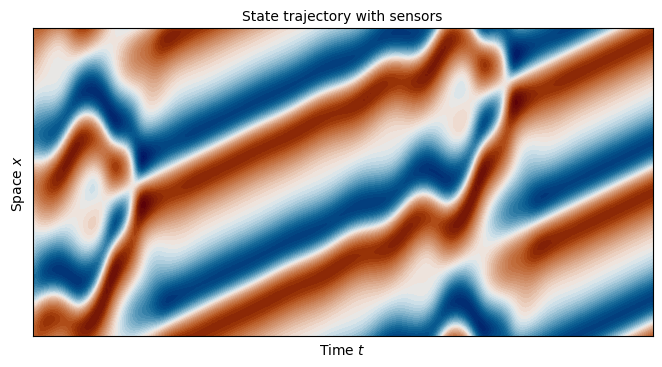

In [34]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_sensors(ut, sensors_coordinates, cmap = cmc.vik, title = None, fontsize = None, ticks = True, colorbar = False, levels = 50, vmax = None, vmin = None):
    """
    State trajectory with sensors
    Input: state trajectory with dimension (ntimes, nstate), sensors coordinates with dimension (nsensors) and plot functionalities
    """

    ntimes = ut.shape[0]
    times = np.linspace(0, T, ntimes)
    step = 10

    for i in np.arange(1, ntimes + step, step):
        
        plt.figure(figsize = (8,4))

        timesgrid, xgrid = np.meshgrid(times[:i+1], x)        
        
        plt.contourf(timesgrid, xgrid, ut[:i+1].t(), cmap = cmap, levels = levels, vmax = vmax, vmin = vmin)

        plt.xlabel(r"Time $t$", fontsize = fontsize)
        plt.ylabel(r"Space $x$", fontsize = fontsize)
        plt.xlim(times[0], times[-1])
        plt.ylim((x[0], x[-1]))
        plt.title(title, fontsize = fontsize)

        if not ticks:
            plt.xticks([], [])
            plt.yticks([], [])
        
        if colorbar:
            plt.colorbar(fig)

        if i < ntimes:
            for k in range(nsensors):
                plt.plot(i, sensors_coordinates[k], 'o', mfc = 'magenta', mec = 'black', ms = 10, mew = 1.5)

        display(plt.gcf())
        plt.close()
        clc(wait = True)

which = 0

trajectory_with_sensors(Utrain[which], sensors_coordinates, title = "State trajectory with sensors", ticks = False)

In [35]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 50

train_data_in = Padding(sensors_data_train, lag).to(device)
valid_data_in = Padding(sensors_data_valid, lag).to(device)
test_data_in = Padding(sensors_data_test, lag).to(device)

train_data_out = Padding(Utrain_POD, 1).squeeze(1).to(device)
valid_data_out = Padding(Uvalid_POD, 1).squeeze(1).to(device)
test_data_out = Padding(Utest_POD, 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [36]:
print(np.shape(train_dataset.X))
print(np.shape(train_dataset.Y))

torch.Size([80400, 50, 2])
torch.Size([80400, 20])


In [37]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(nsensors, kstate, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100)

KeyboardInterrupt: 

In [38]:
# SHRED LOADING

from utils.models import SHRED

shred = SHRED(nsensors, kstate, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load('KuramotoSivashinsky_shred.pt', weights_only = True, map_location = torch.device(device)));

FileNotFoundError: [Errno 2] No such file or directory: 'KuramotoSivashinsky_shred.pt'

In [73]:
# SHRED ERRORS ON TEST DATA

shred.freeze()

Utest_POD_hat = shred(test_data_in).cpu()
Utest_hat = torch.from_numpy(scalerU.inverse_transform(Utest_POD_hat)) @ V
Utest_hat = Utest_hat.reshape(ntest, ntimes, nstate)

print("Mean relative SHRED prediction error on U_POD: %s" % num2p(mre(test_data_out, Utest_POD_hat)))

print("Mean relative SHRED prediction error on U: %s"  % num2p(mre(Utest, Utest_hat)))

Mean relative SHRED prediction error on U_POD: 2.99%
Mean relative SHRED prediction error on U: 10.59%


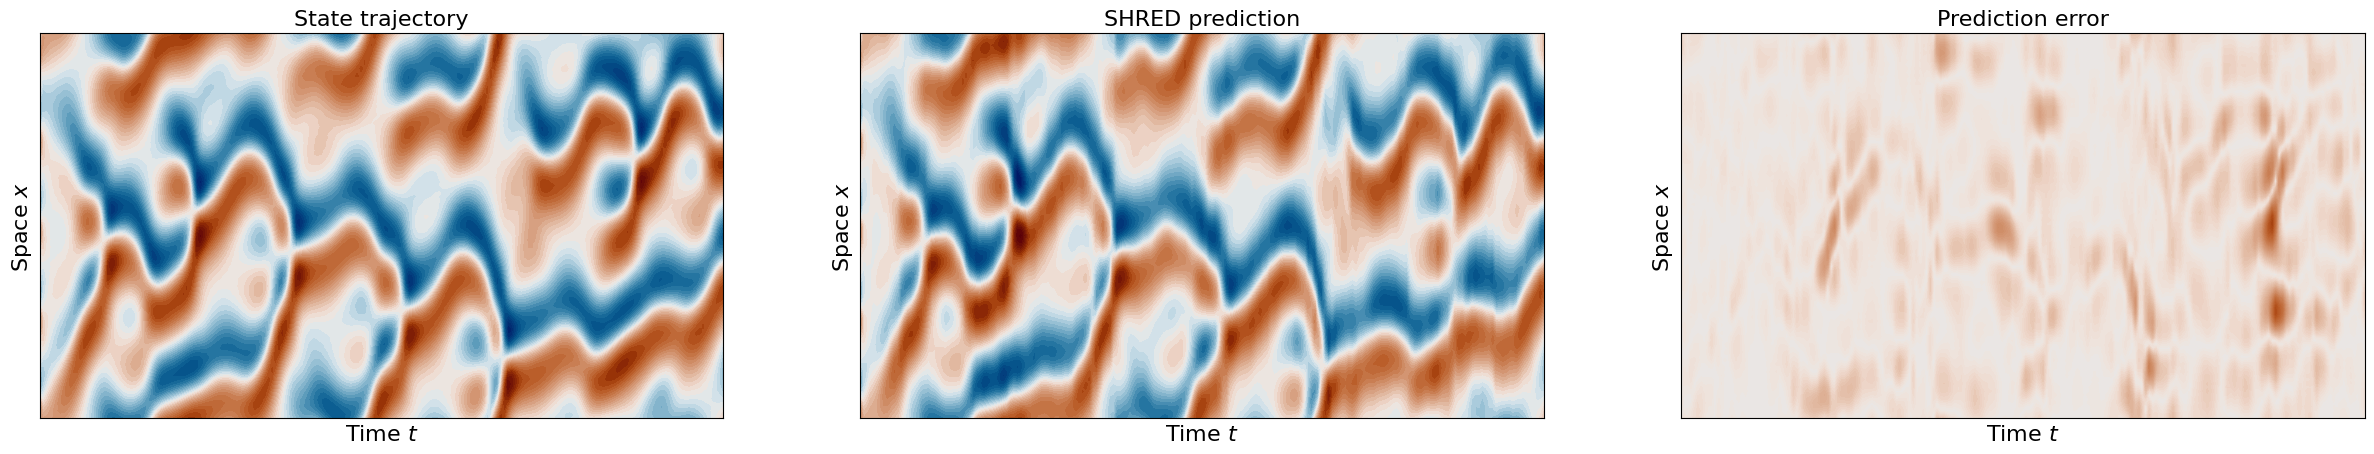

In [30]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectories_with_sensors(uts, sensors_coordinates, cmap = cmc.vik, titles = None, fontsize = None, ticks = True, colorbar = False, levels = 50, vmax = None, vmin = None):
    """
    Trajectories with sensors
    Input: state trajectory with dimension (ntimes, nstate), sensors coordinates with dimension (nsensors) and plot functionalities
    """

    vmin = min(uts[j].min() for j in range(len(uts)))
    vmax = max(uts[j].max() for j in range(len(uts)))

    ntimes = uts[0].shape[0]
    times = np.linspace(0, T, ntimes)
    step = 10
    
    for i in np.arange(1, ntimes + step, step):
        
        plt.figure(figsize = (30, 5))
        
        for j in range(len(uts)):
            
            plt.subplot(1, len(uts), j+1)
        
            timesgrid, xgrid = np.meshgrid(times[:i+1], x)        
        
            plt.contourf(timesgrid, xgrid, uts[j][:i+1].t(), cmap = cmap, levels = levels, vmax = vmax, vmin = vmin)

            plt.xlabel(r"Time $t$", fontsize = fontsize)
            plt.ylabel(r"Space $x$", fontsize = fontsize)
            plt.xlim(times[0], times[-1])
            plt.ylim((x[0], x[-1]))
            plt.title(titles[j], fontsize = fontsize)

            if not ticks:
                plt.xticks([], [])
                plt.yticks([], [])
        
            if colorbar:
                plt.colorbar(fig)

            if i < ntimes and j < len(uts)-1:
                for k in range(nsensors):
                    plt.plot(i, sensors_coordinates[k], 'o', mfc = 'magenta', mec = 'black', ms = 10, mew = 1.5)

        display(plt.gcf())
        plt.close()
        clc(wait = True)

which = 0

plotlist = [Utest[which], Utest_hat[which], ((Utest[which] - Utest_hat[which])**2).sqrt()]

trajectories_with_sensors(plotlist, sensors_coordinates, titles = ("State trajectory", "SHRED prediction", "Prediction error"), fontsize = 16, ticks = False)

torch.Size([10050, 20])


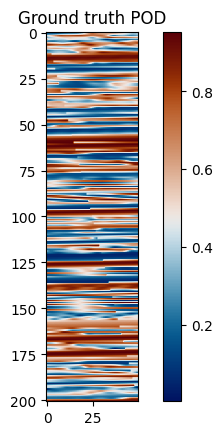

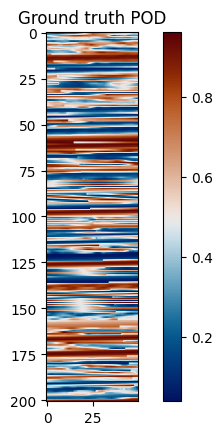

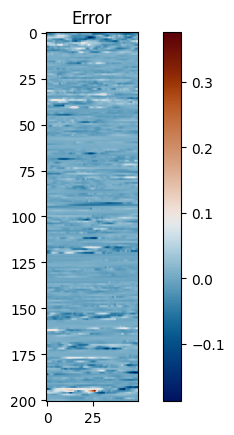

In [87]:
frame = 0
print(np.shape(test_data_out))

plt.figure()
plt.title(f'Ground truth POD')
plt.imshow(test_data_out[:, frame].reshape(201, 50 ), cmc.vik)
plt.colorbar()


plt.figure()
plt.title(f'Ground truth POD')
plt.imshow(shred(test_data_in)[:, frame].reshape(201, 50 ), cmc.vik)
plt.colorbar()


plt.figure()
plt.title(f'Error')
plt.imshow((test_data_out[:, frame].reshape(201, 50 ) - shred(test_data_in)[:, frame].reshape(201, 50 )), cmc.vik)
plt.colorbar()

In [1]:
frame = 0

plt.figure()
plt.title(f'Ground truth')
plt.imshow(Utest_reconstructed[frame].T, cmc.vik)
plt.colorbar()

plt.figure()
plt.title(f'Shred')
plt.imshow(Utest_hat[frame].T , cmc.vik)
plt.colorbar()



plt.figure()
plt.title(f'Error')
plt.imshow((Utest_hat[frame].T - Utest_reconstructed[frame].T), cmc.vik)
plt.colorbar()

NameError: name 'plt' is not defined